In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import classification_model_evaluation as model_eval

%matplotlib inline

In [2]:
RGB_train = pickle.load(open('RGB_train_reduce.pickle', 'rb'))
RGB_test = pickle.load(open('RGB_test_reduce.pickle', 'rb'))
RGB_labels_train = pickle.load(open('RGB_train_labels.pickle', 'rb'))
RGB_labels_test = pickle.load(open('RGB_test_labels.pickle', 'rb'))

print(RGB_train.shape, RGB_test.shape)

(21600, 120) (5400, 120)


In [3]:
dsift_train = pickle.load(open('dsift_train_reduce.pickle', 'rb'))
dsift_test = pickle.load(open('dsift_test_reduce.pickle', 'rb'))
dsift_labels_train = pickle.load(open('dsift_train_labels.pickle', 'rb'))
dsift_labels_test = pickle.load(open('dsift_test_labels.pickle', 'rb'))

print(dsift_train.shape, dsift_test.shape)

(21600, 160) (5400, 160)


In [4]:
dsift_full = pickle.load(open('dsift_features.pickle', 'rb'))
dsift_labels_full = pickle.load(open('dsift_labels.pickle', 'rb'))

print(dsift_full.shape)

(27000, 8192)


In [5]:
k = 8  # 8 cores

#Setup k-fold CV method
kf = KFold(n_splits = k, shuffle = True, random_state = 423)

In [ ]:
k_list = np.arange(1, 21)   # 20 different values of k
knn_acc = {}
knn_f1 = {}

for k in k_list:
    
    # initialize kNN model
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
    acc_list = []
    f1_list = []
    
    for tr, val in kf.split(RGB_train, RGB_labels_train):
        
        # split into training and validation sets for each fold
        X_tr, X_val = RGB_train[tr], RGB_train[val]
        y_tr, y_val = RGB_labels_train[tr], RGB_labels_train[val]
        
        #fit kNN model on training set and predict on validation set
        knn.fit(X_tr, y_tr)
        pred = knn.predict(X_val)
        
        #compute accuracy, f1 score, precision, and recall for predictions
        acc_list.append(accuracy_score(y_val, pred))
        f1_list.append(f1_score(y_val, pred, average = 'weighted'))
    
    # take mean of each metric across all 10 folds
    knn_acc[k] = np.mean(acc_list)
    knn_f1[k] = np.mean(f1_list)

In [15]:
# compile results into dataframe with each value of k as columns
pd.DataFrame([knn_acc, knn_f1], index = ['accuracy', 'f1_score'])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
accuracy,0.434954,0.433796,0.426620,0.434444,0.42875,0.429444,0.425741,0.427037,0.423194,0.423889,0.419954,0.418657,0.416991,0.415972,0.412870,0.413287,0.411991,0.411435,0.410046,0.408750
f1_score,0.394002,0.376541,0.368148,0.375107,0.37017,0.369939,0.365823,0.365311,0.362563,0.362480,0.357977,0.355351,0.353752,0.352459,0.349642,0.349252,0.348674,0.347578,0.346040,0.344325


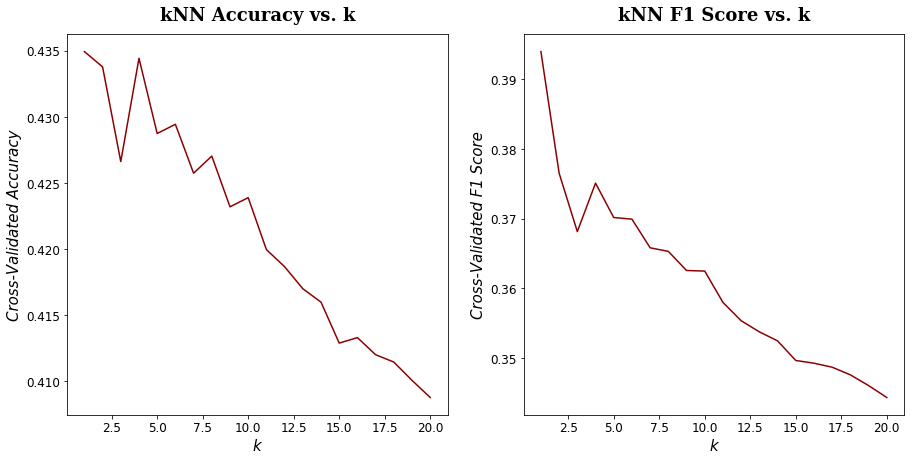

In [17]:
# plot CV accuracy vs. k
plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1)
plt.plot(k_list, list(knn_acc.values()), color = 'darkred')
plt.title("kNN Accuracy vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated Accuracy', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(k_list, list(knn_f1.values()), color = 'darkred')
plt.title("kNN F1 Score vs. k", fontsize = 18, fontweight = 'bold', family = 'serif', y = 1.02)
plt.xlabel('k', style = 'italic', fontsize = 15)
plt.ylabel('Cross-Validated F1 Score', style = 'italic', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 0)
plt.yticks(fontsize = 12)

#plt.savefig('knn_objects_cv.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()

In [7]:
# fit kNN model to whole training set with optimal k
knn = KNeighborsClassifier(n_neighbors = 4, n_jobs = -1).fit(RGB_train, RGB_labels_train)
knn_metrics = model_eval.compute_metrics(knn, RGB_test, RGB_labels_test)
knn_metrics

{'accuracy': 0.43074074074074076,
 'f1_score': 0.3704222771922778,
 'precision': 0.4795879651855957,
 'recall': 0.43074074074074076,
 'specificity': nan,
 'log_loss': 13.711044709326277,
 'auc': 0.7550465701373141}

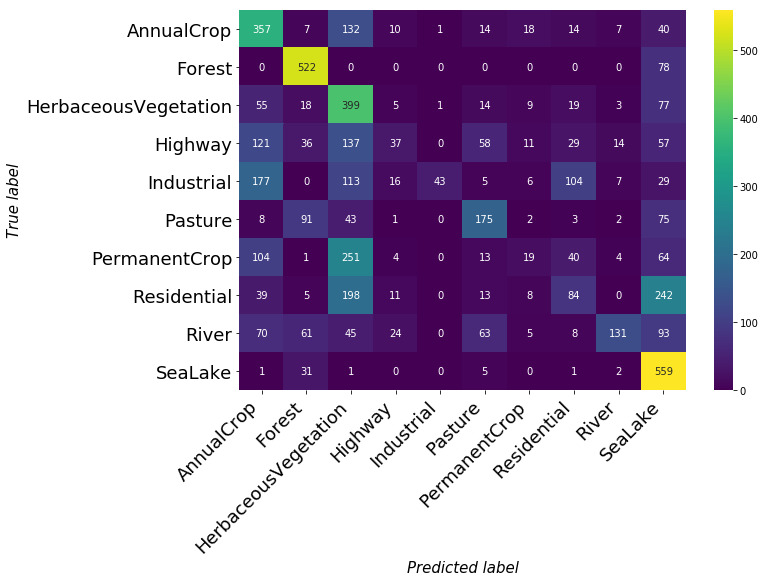

In [12]:
# kNN confusion matrix
labels = np.unique(RGB_labels_test)
knn_cm = confusion_matrix(RGB_labels_test, knn.predict(RGB_test), labels = labels)
model_eval.print_confusion_matrix(knn_cm, labels)

In [13]:
knn2 = KNeighborsClassifier(n_neighbors = 4, n_jobs = -1).fit(dsift_train, dsift_labels_train)
knn_metrics2 = model_eval.compute_metrics(knn2, dsift_test, dsift_labels_test)
knn_metrics2

{'accuracy': 0.3,
 'f1_score': 0.2814226395377577,
 'precision': 0.3592379065424412,
 'recall': 0.3,
 'specificity': nan,
 'log_loss': 17.68888317446651,
 'auc': 0.6631190079050138}

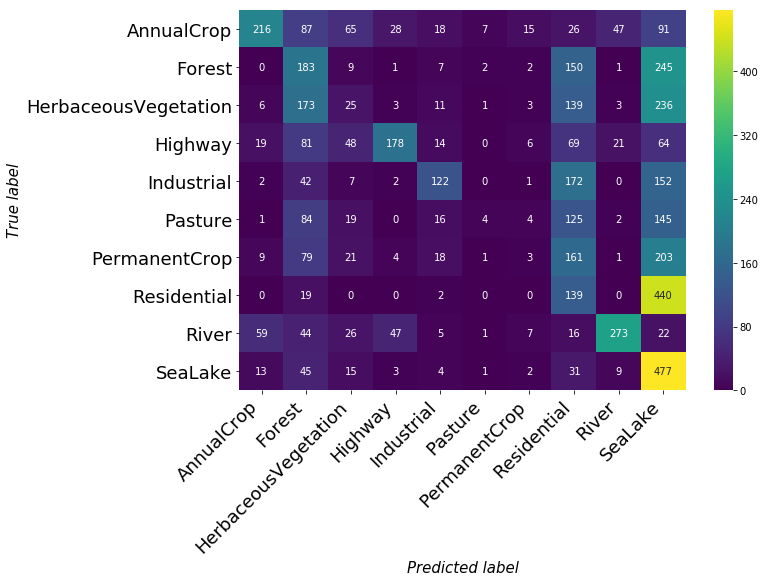

In [14]:
knn_cm2 = confusion_matrix(dsift_labels_test, knn2.predict(dsift_test), labels = labels)
model_eval.print_confusion_matrix(knn_cm2, labels)

In [46]:
# fit naive bayes classifier to training set and evaluate with test set
nb = GaussianNB().fit(RGB_train, RGB_labels_train)
nb_metrics = model_eval.compute_metrics(nb, RGB_test, RGB_labels_test)
nb_metrics

{'accuracy': 0.41888888888888887,
 'f1_score': 0.4054698498563742,
 'precision': 0.4535707267094482,
 'recall': 0.41888888888888887,
 'specificity': nan,
 'log_loss': 10.078170032641577,
 'auc': 0.8334314233591585}

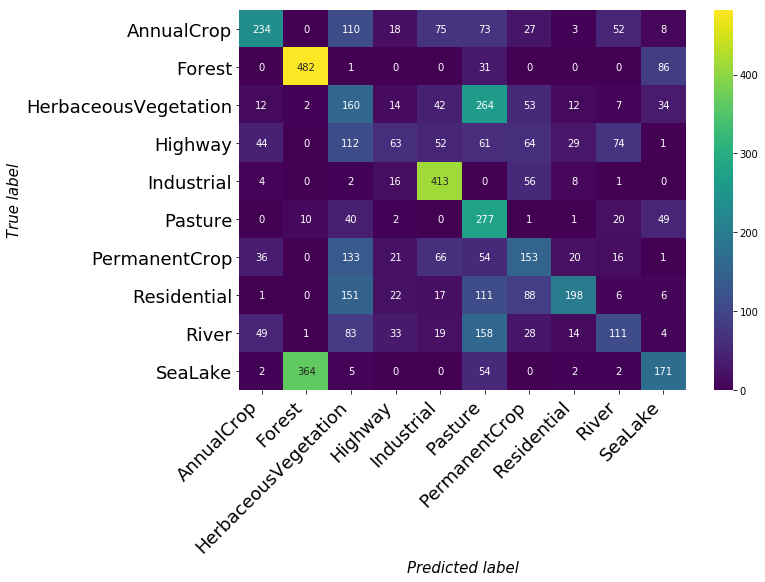

In [47]:
nb_cm = confusion_matrix(RGB_labels_test, nb.predict(RGB_test), labels = labels)
model_eval.print_confusion_matrix(nb_cm, labels)

In [48]:
nb2 = GaussianNB().fit(dsift_train, dsift_labels_train)
nb_metrics2 = model_eval.compute_metrics(nb2, dsift_test, dsift_labels_test)
nb_metrics2

{'accuracy': 0.5018518518518519,
 'f1_score': 0.4946550659497611,
 'precision': 0.500807497397994,
 'recall': 0.5018518518518519,
 'specificity': nan,
 'log_loss': 2.067537768882356,
 'auc': 0.8628028544658604}

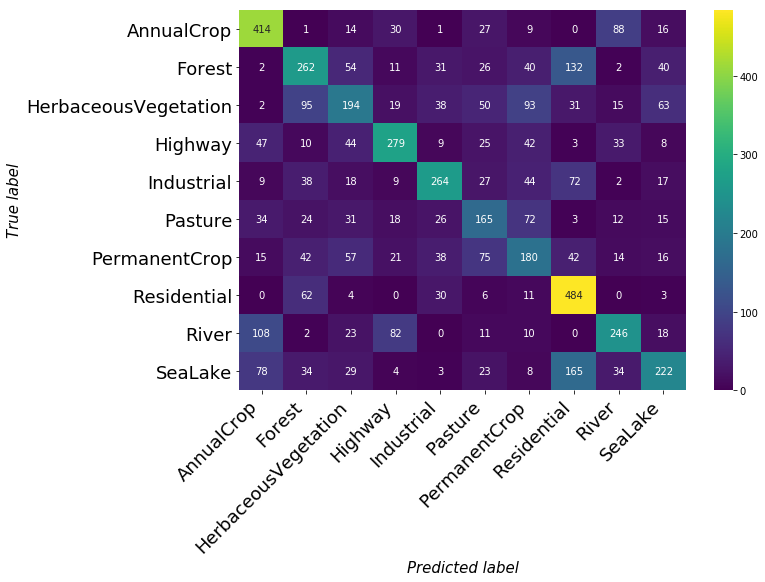

In [49]:
nb_cm2 = confusion_matrix(dsift_labels_test, nb2.predict(dsift_test), labels = labels)
model_eval.print_confusion_matrix(nb_cm2, labels)

In [6]:
dsift_full = dsift_full - dsift_full.mean()
dsift_labels_full = np.asarray(dsift_labels_full)

dsift_full_train, dsift_full_test, dsift_full_labels_train, dsift_full_labels_test = \
    train_test_split(dsift_full, dsift_labels_full, test_size = 0.2, random_state = 423, 
                     stratify = dsift_labels_full)

In [30]:
nb3 = GaussianNB().fit(dsift_full_train, dsift_full_labels_train)
nb_metrics3 = model_eval.compute_metrics(nb3, dsift_full_test, dsift_full_labels_test)
nb_metrics3

{'accuracy': 0.4235185185185185,
 'f1_score': 0.408986899090891,
 'precision': 0.408893723373061,
 'recall': 0.4235185185185185,
 'specificity': nan,
 'log_loss': 19.01967377581927,
 'auc': 0.8183848303728899}

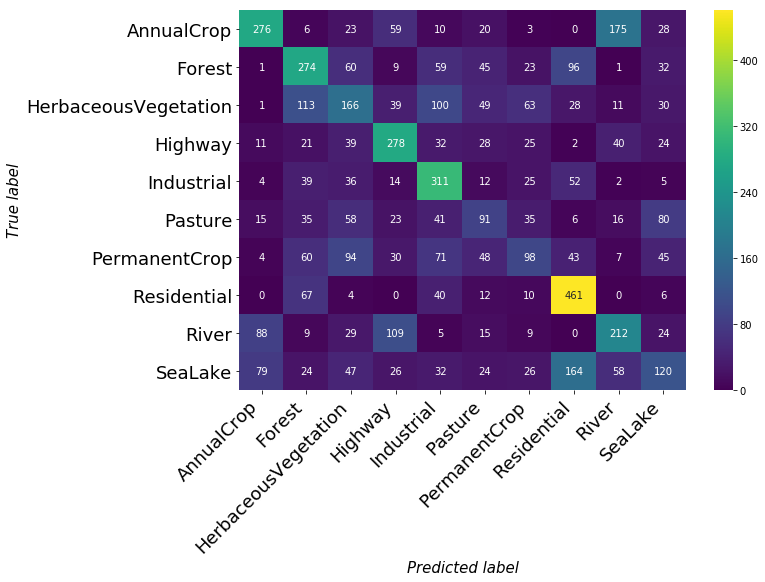

In [31]:
nb_cm3 = confusion_matrix(dsift_full_labels_test, nb3.predict(dsift_full_test), labels = labels)
model_eval.print_confusion_matrix(nb_cm3, labels)

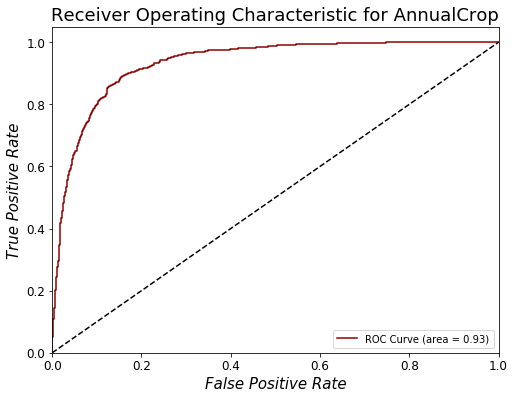

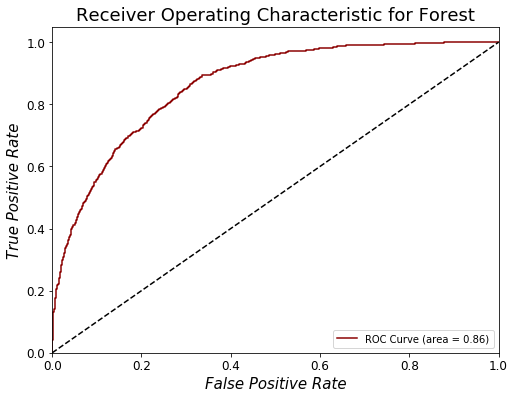

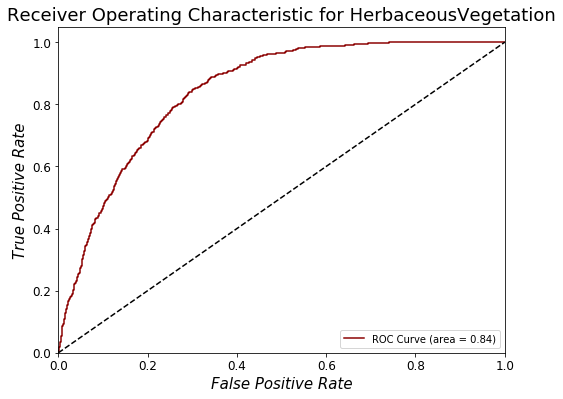

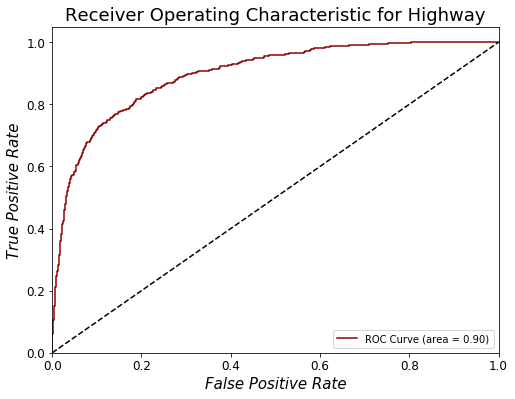

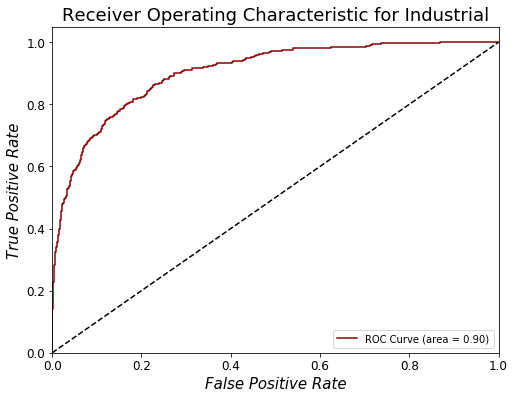

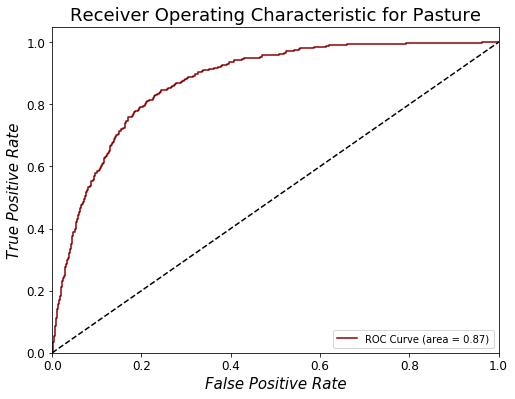

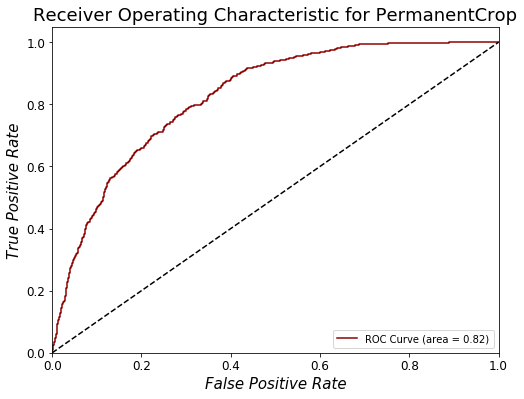

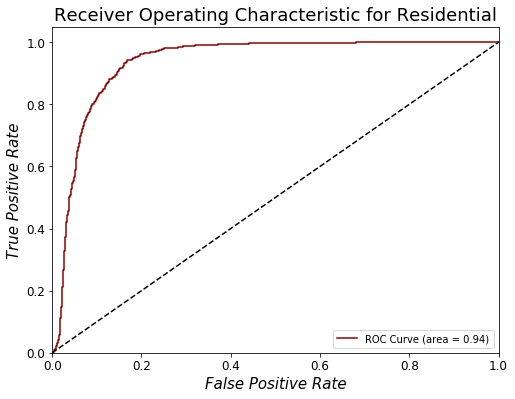

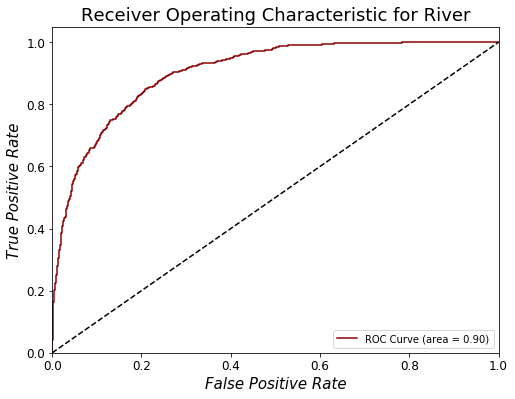

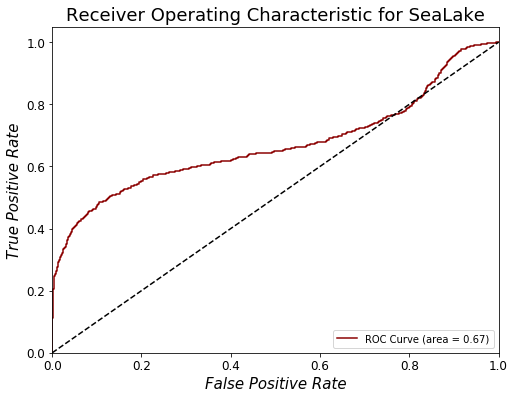

In [33]:
# plot ROC curve for each class (best Naive Bayes model)
model_eval.roc_curve_multiclass(nb2, dsift_test, dsift_labels_test)

In [10]:
# take small subset of data for parameter grid search
RGB_x, _, RGB_y, _ = train_test_split(RGB_train, RGB_labels_train, train_size = 0.1, 
                                      random_state = 423, stratify = RGB_labels_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
RF = RandomForestClassifier(n_jobs = -1, random_state = 423, n_estimators = 100)
param_grid = dict(min_samples_split = [5, 10, 25], 
                  max_features = [None, 10, 25], 
                  bootstrap = [True, False]
                 )

RF_grid = GridSearchCV(RF, param_grid, scoring = 'accuracy', n_jobs = -1, cv = 5)
RF_grid.fit(RGB_x, RGB_y)

print(RF_grid.best_score_)
print(RF_grid.best_params_) 
print(RF_grid.best_estimator_)

0.600462962962963
{'bootstrap': False, 'max_features': 25, 'min_samples_split': 10}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=423, verbose=0, warm_start=False)


In [17]:
dsift_x, _, dsift_y, _ = train_test_split(dsift_train, dsift_labels_train, train_size = 0.1, 
                                          random_state = 423, stratify = RGB_labels_train)

RF_grid2 = GridSearchCV(RF, param_grid, scoring = 'accuracy', n_jobs = -1, cv = 5)
RF_grid2.fit(dsift_x, dsift_y)

print(RF_grid2.best_score_)
print(RF_grid2.best_params_) 
print(RF_grid2.best_estimator_)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.40555555555555556
{'bootstrap': False, 'max_features': 25, 'min_samples_split': 10}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=423, verbose=0, warm_start=False)


In [ ]:
RF = RandomForestClassifier(n_estimators = 500, 
                            max_features = 25, 
                            min_samples_split = 10, 
                            bootstrap = False, 
                            n_jobs = -1, 
                            random_state = 423
                           )

RF.fit(RGB_train, RGB_labels_train)

In [22]:
RF_metrics = model_eval.compute_metrics(RF, RGB_test, RGB_labels_test)
RF_metrics

{'accuracy': 0.6938888888888889,
 'f1_score': 0.6852575468360995,
 'precision': 0.6931638116825317,
 'recall': 0.6938888888888889,
 'specificity': nan,
 'log_loss': 1.0474447622713634,
 'auc': 0.941863827680146}

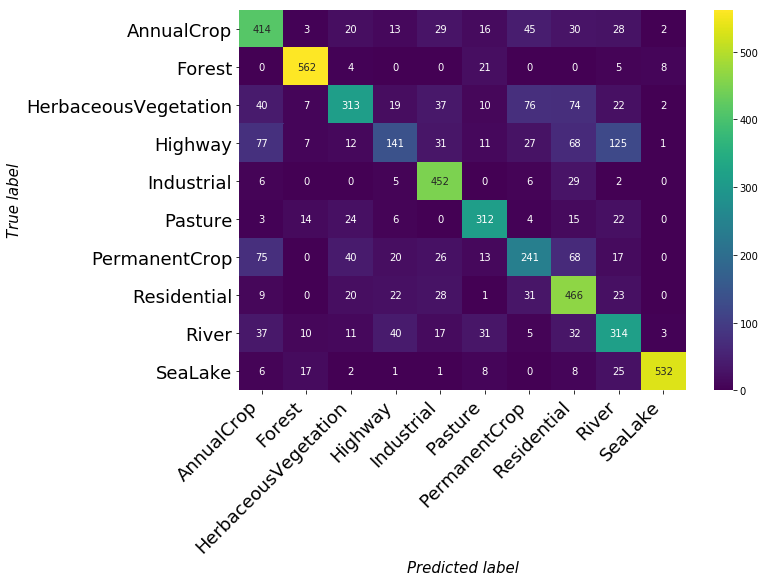

In [24]:
RF_cm = confusion_matrix(RGB_labels_test, RF.predict(RGB_test), labels = labels)
model_eval.print_confusion_matrix(RF_cm, labels)

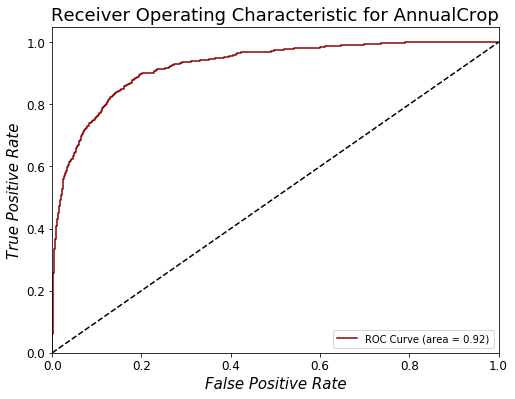

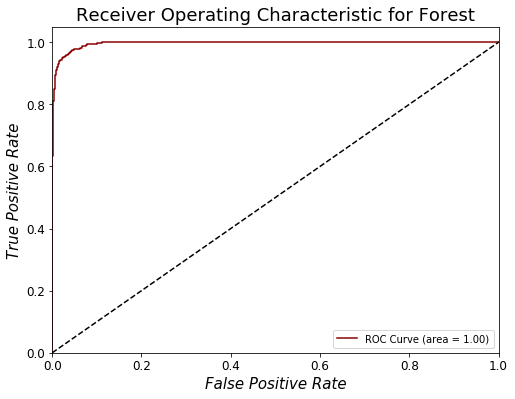

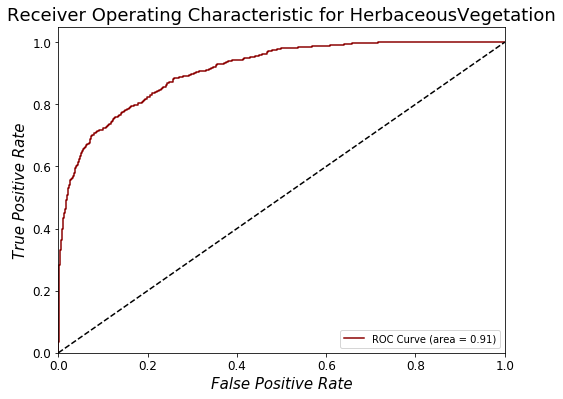

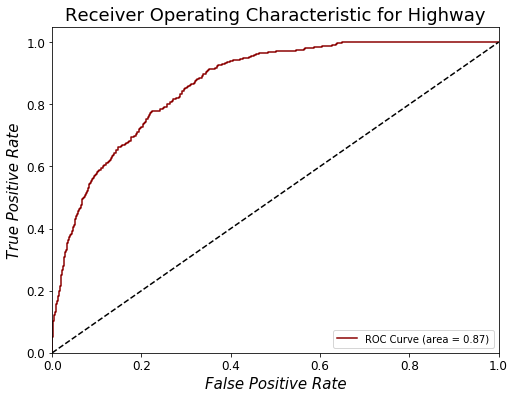

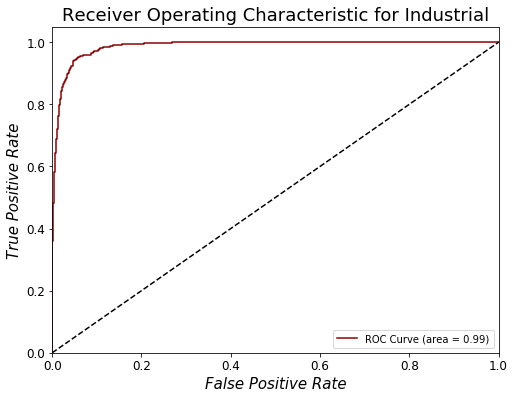

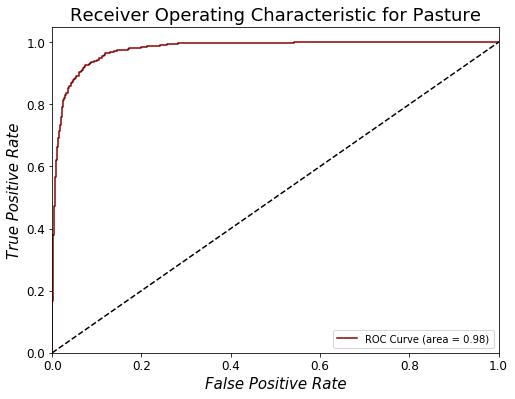

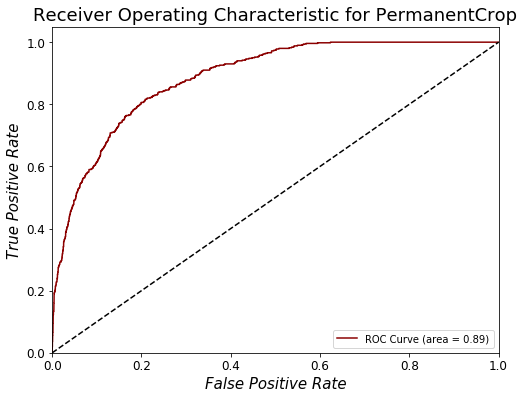

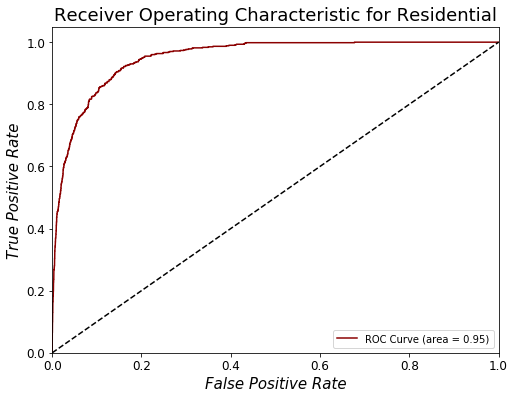

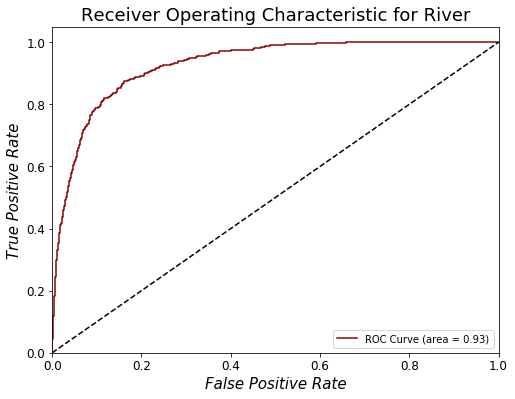

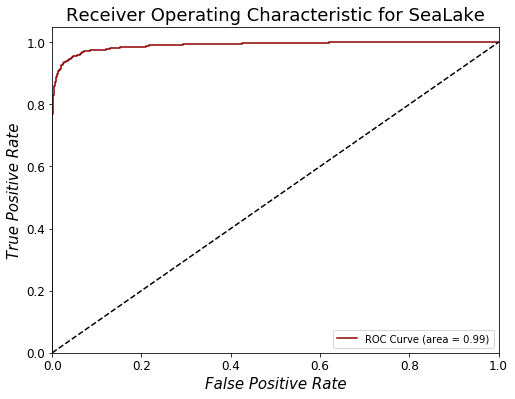

In [25]:
model_eval.roc_curve_multiclass(RF, RGB_test, RGB_labels_test)

In [30]:
ada = AdaBoostClassifier(algorithm = 'SAMME.R', random_state = 423)
ada_param_grid = dict(n_estimators = [50, 100, 500], 
                      learning_rate = [0.1, 1]
                     )

ada_grid = GridSearchCV(ada, ada_param_grid, scoring = 'accuracy', n_jobs = -1, cv = 5)
ada_grid.fit(RGB_x, RGB_y)

print(ada_grid.best_score_)
print(ada_grid.best_params_)

0.35509259259259257
{'learning_rate': 0.1, 'n_estimators': 500}


In [36]:
ada = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.1, algorithm = 'SAMME.R', random_state = 423)
ada.fit(RGB_train, RGB_labels_train)
ada_metrics = model_eval.compute_metrics(ada, RGB_test, RGB_labels_test)
ada_metrics

{'accuracy': 0.1925925925925926,
 'f1_score': 0.16773684095791752,
 'precision': 0.2635816091523314,
 'recall': 0.1925925925925926,
 'specificity': nan,
 'log_loss': 2.160028319112379,
 'auc': 0.7227737148211136}

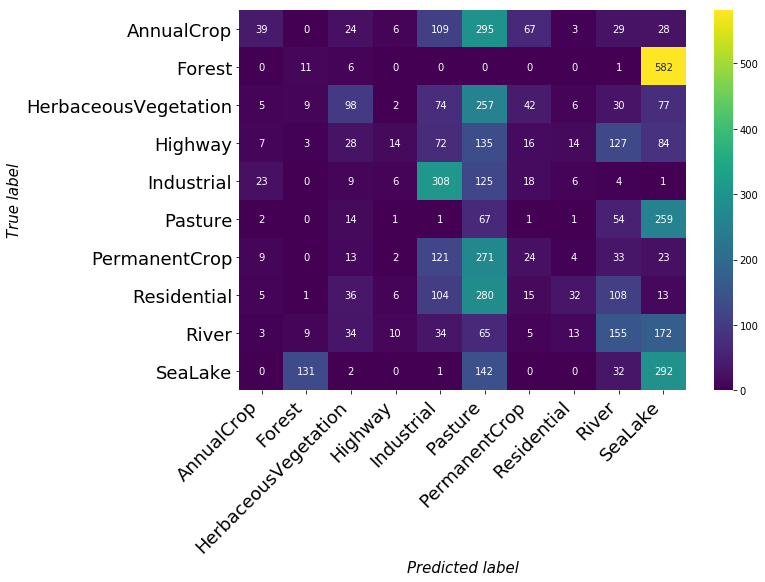

In [37]:
ada_cm = confusion_matrix(RGB_labels_test, ada.predict(RGB_test), labels = labels)
model_eval.print_confusion_matrix(ada_cm, labels)

In [34]:
ada = AdaBoostClassifier(algorithm = 'SAMME.R', random_state = 423)
ada_grid2 = GridSearchCV(ada, ada_param_grid, scoring = 'accuracy', n_jobs = -1, cv = 5)
ada_grid2.fit(dsift_x, dsift_y)

print(ada_grid2.best_score_)
print(ada_grid2.best_params_)

0.29398148148148145
{'learning_rate': 0.1, 'n_estimators': 500}


In [38]:
extratrees = ExtraTreesClassifier(n_estimators = 500, 
                                  min_samples_split = 10, 
                                  max_features = 25, 
                                  bootstrap = False, 
                                  n_jobs = -1, 
                                  random_state = 423
                                 )

extratrees.fit(RGB_train, RGB_labels_train)
extra_metrics = model_eval.compute_metrics(extratrees, RGB_test, RGB_labels_test)
extra_metrics

{'accuracy': 0.687037037037037,
 'f1_score': 0.6726883650858614,
 'precision': 0.6861144477454082,
 'recall': 0.687037037037037,
 'specificity': nan,
 'log_loss': 1.1908169374780748,
 'auc': 0.9359992954617032}

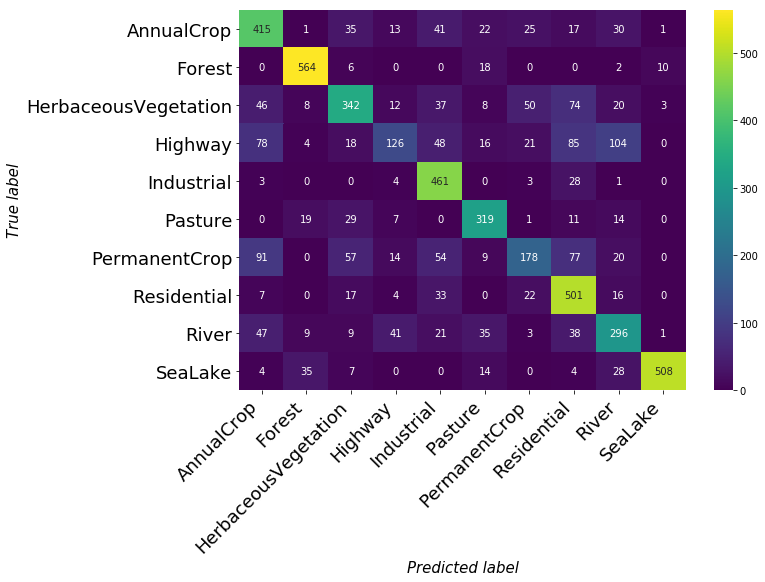

In [39]:
extra_cm = confusion_matrix(RGB_labels_test, extratrees.predict(RGB_test), labels = labels)
model_eval.print_confusion_matrix(extra_cm, labels)

In [50]:
pickle.dump(nb2, open('naive_bayes_dsift_model.pickle', 'wb'))